In [1]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as psu
import matplotlib.pyplot as plt

from waffles.data_classes.WaveformSet import WaveformSet
from waffles.data_classes.Waveform import Waveform


In [8]:
endpoint = 111
runnumber = 26254
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet

file = f'/eos/home-h/hvieirad/waffles/analysis/rawdata/waffles_tau_slow_protoDUNE_HD/{endpoint}/wfset_run0{runnumber}.pkl'

wfset = pickle_file_to_WaveformSet(file)


In [9]:
from extract_selection import Extractor

extractor = Extractor("response", runnumber)

In [10]:
countch = {}
for wf in wfset.waveforms:
    wf:Waveform
    if wf.channel not in countch:
        countch[wf.channel] = 1
    else:
        countch[wf.channel]+=1
    
for k,v in countch.items():
    print(k, v)

11112 25043
11114 36852
11116 26618
11110 19695
11113 33224
11115 24500
11117 25153
11111 37461


In [11]:
extractor.loadcuts()
extractor.skeepcuts=False
wfset_ch = WaveformSet.from_filtered_WaveformSet( wfset, extractor.allow_certain_endpoints_channels, [endpoint] , [11114])
len(wfset_ch.waveforms)


3076

(0.0, 200.0)

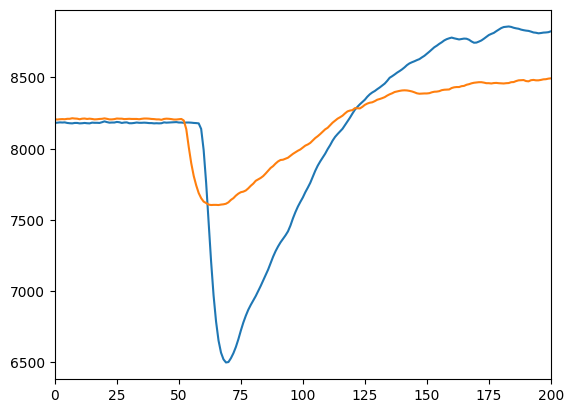

In [179]:
import numpy as np
i=0
# a=wfset.waveforms[i].adcs
plt.plot(np.roll(a,0))
plt.plot(wfset.waveforms[i].adcs)
plt.xlim(0,200)

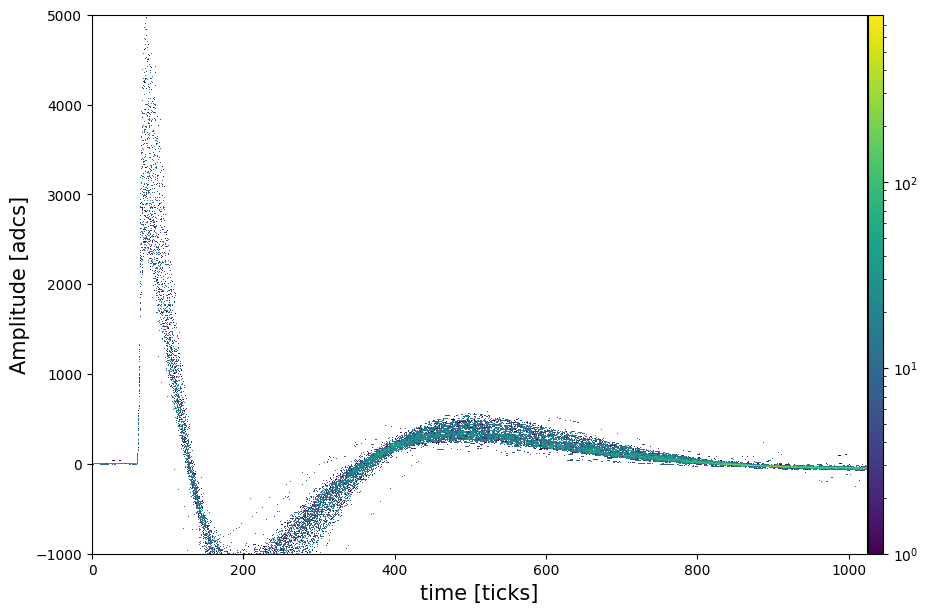

: 

In [13]:
import pickle
import numpy as np
from waffles.utils.denoising.tv1ddenoise import Denoise

times = np.linspace(0, 1024, 1024, endpoint=False)
time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
wvf_arrays = np.array([(waveform.filtered - waveform.baseline)*-1 for waveform in wfset_ch.waveforms])


h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(6000,1024), range = [[-1000,5000],[0,1024]])
h[h==0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10,7))

x, y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(x, y, h, norm='log')
ax.set_ylabel("Amplitude [adcs]", fontsize=15)
ax.set_xlabel("time [ticks]", fontsize=15)
cax = ax.inset_axes([1.001, 0., 0.02, 1.])
plt.colorbar(pcm, ax=ax, cax=cax)

avgwvf = np.mean(wvf_arrays, axis=0)
# res0, status = extractor.baseliner.compute_baseline(avgwvf)
# avgwvf-=res0
# plt.plot(avgwvf, '-k', lw=2)
# wfset_ch.avgwvf = avgwvf
# plt.xlim(50,200)
# plt.ylim(-500,1000)
# pickleavgname = f'templates/template_run0{runnumber}.pkl'
# with open(pickleavgname, "wb") as f:
#     pickle.dump(wfset_ch, f)


(50.0, 200.0)

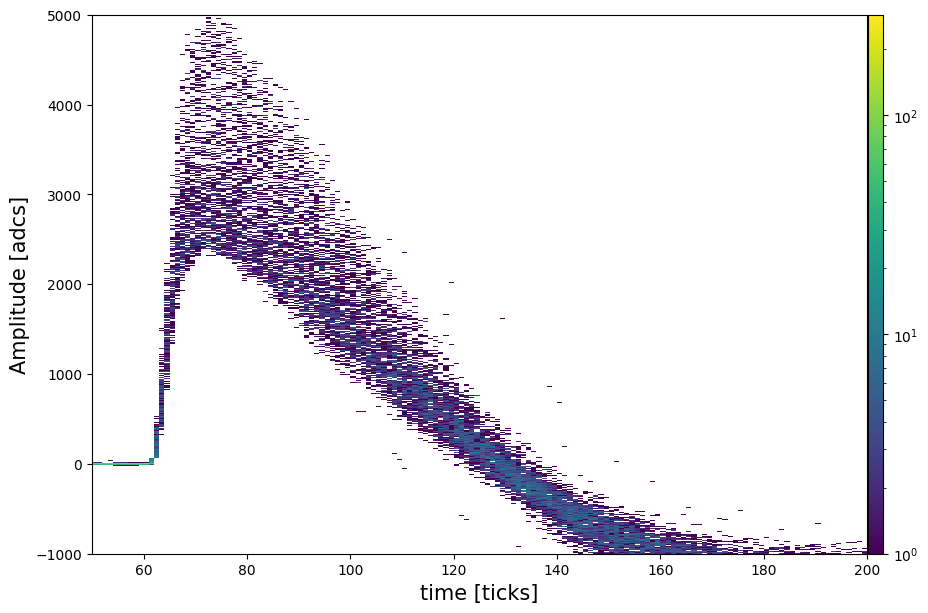

In [7]:
import pickle
import numpy as np
from waffles.utils.denoising.tv1ddenoise import Denoise

times = np.linspace(0, 1024, 1024, endpoint=False)
time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
wvf_arrays = np.array([(waveform.filtered - waveform.baseline)*-1 for waveform in wfset_ch.waveforms])


h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(6000,1024), range = [[-1000,5000],[0,1024]])
h[h==0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10,7))

x, y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(x, y, h, norm='log')
ax.set_ylabel("Amplitude [adcs]", fontsize=15)
ax.set_xlabel("time [ticks]", fontsize=15)
cax = ax.inset_axes([1.001, 0., 0.02, 1.])
plt.colorbar(pcm, ax=ax, cax=cax)

avgwvf = np.mean(wvf_arrays, axis=0)
# res0, status = extractor.baseliner.compute_baseline(avgwvf)
# avgwvf-=res0
# plt.plot(avgwvf, '-k', lw=2)
# wfset_ch.avgwvf = avgwvf
plt.xlim(50,200)
# plt.ylim(-500,1000)
# pickleavgname = f'templates/template_run0{runnumber}.pkl'
# with open(pickleavgname, "wb") as f:
#     pickle.dump(wfset_ch, f)
